### Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import hsmm_mvpy as hmp
from pathlib import Path
from mne.io import read_info
from hmpai.data import StageFinder, SAT1_STAGES_ACCURACY, SAT1_STAGES_SPEED, SAT2_STAGES_ACCURACY, SAT2_STAGES_SPEED, AR_STAGES
import scipy
import matplotlib.pyplot as plt

Transforming epoched data to principal component (PC) space


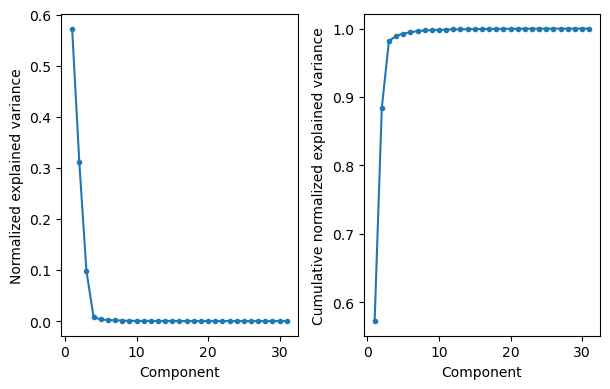

Fitting HMP model
Estimating 6 events model with 100 starting point(s)


  0%|          | 0/100 [00:00<?, ?it/s]

In [2]:
cpus = 12

epoched_data_path = Path("../data/ar/data.nc")
output_path = Path("../data/ar/stage_data_extra_stage.nc")
labels = AR_STAGES

stage_finder = StageFinder(
    epoched_data_path,
    labels,
    cpus=cpus,
    fit_function="fit_single",
    fit_args={"starting_points": 100},
    n_comp=5,
)
stage_finder.fit_model()

In [3]:
channel_data = scipy.io.loadmat(Path("../data/ar/chanlocs.mat"))
channels = [channel_data["chanlocs"][0][i][0][0] for i in range(32)]
channels
# Create new channel ordering to adhere as close as possible to SAT 1 ordering
reindex_channels = channels.copy()
reindex_channels[1] = "FP2"
reindex_channels[2] = "FPZ"
reindex_channels[8:13] = channels[13:18]
reindex_channels[13:18] = channels[23:28]
reindex_channels[18:19] = ["O1", "O2"]
reindex_channels[20:25] = ["FC3", "FCZ", "FC4", "FT7", "FT8"]
reindex_channels[25:30] = channels[18:23]
reindex_channels[30:33] = ["trash1", "trash2"]

In [59]:
for channel in channel_data["chanlocs"][0]:
    # Label ['FP1', ...]
    # Type []
    # Theta looks like X
    # Radius
    # X
    # Y
    # Z
    # sph_theta
    # sph_phi
    # sph_radius
    # urchan
    # ref
    print(channel[5])

[[26.1330144]]
[[0]]
[[-26.1330144]]
[[68.42333503]]
[[48.20042732]]
[[0]]
[[-48.14259647]]
[[-68.3835903]]
[[80.41001431]]
[[59.27497818]]
[[0]]
[[-59.27497818]]
[[-80.41001431]]
[[84.53853864]]
[[63.17128071]]
[[0]]
[[-63.16731017]]
[[-84.53853864]]
[[80.41001431]]
[[59.27497818]]
[[-4.03250273e-15]]
[[-59.27497818]]
[[-80.38510212]]
[[68.42333503]]
[[48.20042732]]
[[-7.43831863e-15]]
[[-48.14259647]]
[[-68.3835903]]
[[-9.67783732e-15]]
[[26.1330144]]
[[-1.04071996e-14]]
[[-26.1330144]]


In [4]:
positions = np.empty((32, 2), dtype=np.float32)
pos_dict = {}
for channel in channel_data["chanlocs"][0]:
    # print(channel)
    ch_name = channel[0][0]
    ch_x = channel[5][0].item() / 1000
    ch_y = channel[4][0].item() / 1000
    pos_dict[ch_name] = (ch_x, ch_y)
for i, ch in enumerate(channels):
    positions[i] = pos_dict[ch]
# for i, ch in enumerate(reindex_channels):
#     if ch == "trash1" or ch == "trash2":
#         continue
#     positions[i] = pos_dict[ch]

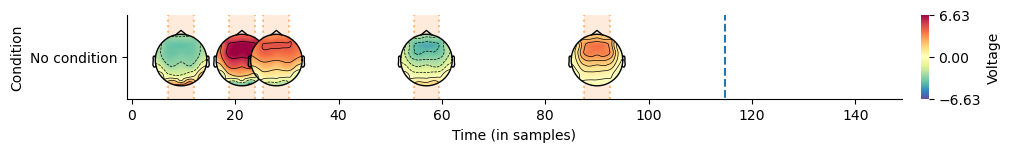

In [5]:
# Visualize model to check if fitting was done as expected
stage_finder.visualize_model(positions)

In [11]:
stage_data = stage_finder.label_model()

Labeling dataset for No condition condition
Processing participant AR_1
Processing participant AR_2
Processing participant AR_3
Processing participant AR_4
Processing participant AR_5
Processing participant AR_6
Processing participant AR_7
Processing participant AR_8
Processing participant AR_9
Processing participant AR_10
Processing participant AR_11
Processing participant AR_12
Processing participant AR_13
Processing participant AR_14
Processing participant AR_15
Processing participant AR_16
Processing participant AR_17
Processing participant AR_18
Processing participant AR_19
Processing participant AR_20


In [12]:
# Save labelled dataset
stage_data.to_netcdf(output_path)

In [13]:
hmp.utils.save_fit(stage_finder.fits[0], "../models/hmp/100hz_ar.nc")

../models/hmp/100hz_ar.nc saved


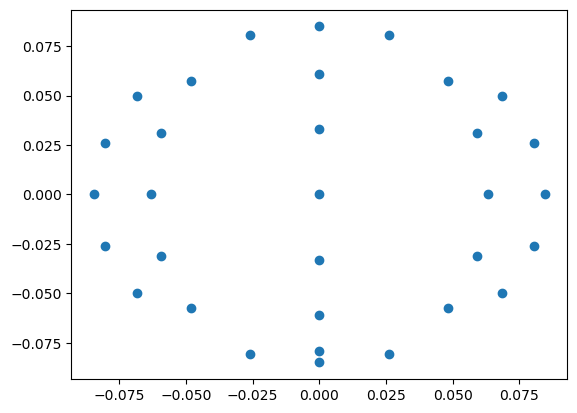

In [5]:
plt.scatter(positions[:, 0], positions[:, 1])

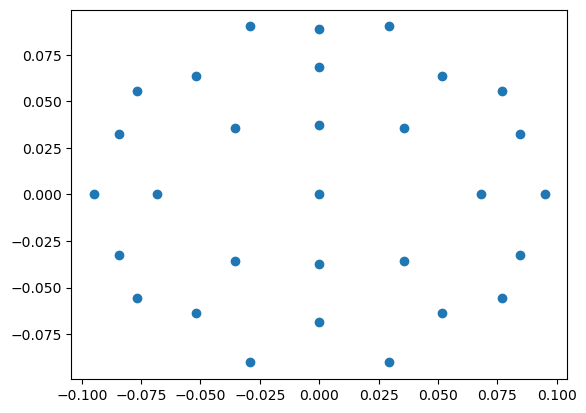

In [124]:
mne_info = read_info(Path("../data/sat1/preprocessed/processed_0001_epo.fif"))
mne_positions = np.empty((30, 2))
for i, pos in enumerate(mne_info["chs"]):
    # print(pos["ch_name"])
    # print(pos["loc"])
    mne_positions[i] = pos["loc"][[0, 1]]
plt.scatter(mne_positions[:, 0], mne_positions[:, 1])